In [50]:
#https://israelg99.github.io/2017-02-27-Grayscale-PixelCNN-with-Keras/

import geopandas as gpd
import pandas as pd
import math
import glob

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#from tqdm import tqdm
from itertools import chain
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Embedding
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

In [51]:
pixel_dir='/home/jupyter/NeuralNetwork/Pixels/'
input_data_dir='/home/jupyter/NeuralNetwork/Inputs/'

def rescale_x(df):
    
    #pca = PCA(n_components=3)
    #pca.fit(df)
    #columns = ['pca_%i' % i for i in range(3)]
    #df_pca = pd.DataFrame(pca.transform(df), columns=columns, index=df.index)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=['ring','landcover','elevation','pop_sqkm','t0','t_max','temp','prcp','wdsp'])

    
    return scaled_df

def generate_matrix_from_df(fire):

    pixels=gpd.read_file(pixel_dir+fire+'_pixels.shp')
    #print(pixels.shape)
    #pixels.columns=['index_righ', 'us_gid_to_', 'Unnamed_ 0', 'on_fire', 'fire_start','ring', 'landcover', 'elevation', 'pop_sqkm', 'x_co', 'y_co', 'x_rank','y_rank', 'pixel_orde', 'geometry']
    pixels=pixels[['on_fire','fire_start','ring','landcover','elevation','pop_sqkm','temp','prcp','wdsp','x_rank','y_rank']]
    pixels['t0']=0
    pixels.loc[pixels['fire_start']==0 & pixels['fire_start'].notnull(),'t0']=1
    pixels.loc[pixels['ring']==0 & pixels['ring'].notnull(),'ring']=0.5
    fire_pix=pixels[pixels['on_fire']==1]
    #pixels['t_max']=fire_pix['fire_start'].max()
    if fire_pix['fire_start'].max()==0:
        max_time=1
    else:
        max_time=fire_pix['fire_start'].max()
        
    pixels.loc[pixels['ring'].notnull(),'t_max']=max_time
    #print(fire_pix['fire_start'].max())
    pixels.loc[pixels['fire_start']==0,'t0']=1
    

    pixels=pixels[['on_fire','ring','landcover','elevation','pop_sqkm','t0','t_max','temp','prcp','wdsp','x_rank','y_rank']]

    pixels = pixels.sort_values(['y_rank', 'x_rank'], ascending=[1, 1]).fillna(0)
    pixels=pixels[['on_fire','ring','landcover','elevation','pop_sqkm','t0','t_max','temp','prcp','wdsp']]

    return pixels




In [52]:
allFiles = glob.glob(input_data_dir + "*.csv")
allFiles_df=pd.DataFrame(v.replace('/home/jupyter/NeuralNetwork/Inputs/','').replace('.csv','') for v in allFiles)
allFiles_df.columns=['fire_id']

train_ids, test_ids =train_test_split(allFiles_df, test_size=0.15)

train_df = pd.DataFrame(columns=['on_fire','ring','landcover','elevation','pop_sqkm','t0','t_max','temp','prcp','wdsp'])

for i,ide in train_ids.iterrows():
    try:
        train_df = train_df.append(generate_matrix_from_df(ide['fire_id']))
    except:
        train_ids=train_ids[train_ids['fire_id']!=ide['fire_id']]

        
        
test_df = pd.DataFrame(columns=['on_fire','ring','landcover','elevation','pop_sqkm','t0','t_max','temp','prcp','wdsp'])

for i,ide in test_ids.iterrows():
    try:
        test_df = test_df.append(generate_matrix_from_df(ide['fire_id']))
    except:
        test_ids=test_ids[test_ids['fire_id']!=ide['fire_id']]
#print(train_df.head(10))


#trainY


In [53]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 9

trainX_df=rescale_x(train_df[['ring','landcover','elevation','pop_sqkm','t0','t_max','temp','prcp','wdsp']]).values
#trainX_df=train_df[['t0']].values
trainY_df=train_df[['on_fire']].values
X_train = trainX_df.reshape((train_ids.shape[0],IMG_WIDTH, IMG_HEIGHT,IMG_CHANNELS)).astype( dtype=np.float64 )
Y_train = trainY_df.reshape(train_ids.shape[0],IMG_WIDTH, IMG_HEIGHT,1).astype( dtype=np.bool )

testX_df=rescale_x(test_df[['ring','landcover','elevation','pop_sqkm','t0','t_max','temp','prcp','wdsp']]).values
#testX_df=test_df[['t0']].values
testY_df=test_df[['on_fire']].values
X_test = testX_df.reshape((test_ids.shape[0],IMG_WIDTH, IMG_HEIGHT,IMG_CHANNELS)).astype( dtype=np.float64 )
Y_test = testY_df.reshape(test_ids.shape[0],IMG_WIDTH, IMG_HEIGHT,1).astype( dtype=np.bool )

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/jupyter/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


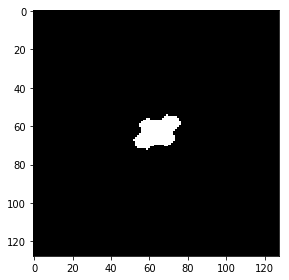

/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


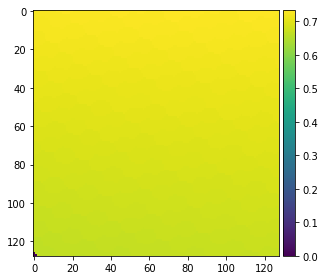

In [54]:
#Y_train = trainY_df.reshape(train_ids.shape[0],IMG_WIDTH, IMG_HEIGHT,1).astype( 'float' )
#ix = random.randint(0, len(train_ids))
#imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][10]))
#print(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):]).shape)
#print(int(Y_train.shape[0]*0.9))
#Y_train[int(Y_train.shape[0]*0.7):][11]


imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.1):][82]))
plt.show()
a_f1 = X_train[:,:,:,8]
imshow(np.squeeze(a_f1[int(a_f1.shape[0]*0.1):][82]))
plt.show()




In [71]:

#https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/notebook


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.2, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = Lambda(lambda x: x / 255) (inputs)
s = Lambda(lambda x: x / 1) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 9)  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 128, 128, 9)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 8)  656         lambda_7[0][0]                   
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 128, 128, 8)  584         conv2d_115[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [72]:
earlystopper = EarlyStopping(patience=20,monitor='val_mean_iou', mode='max', verbose=1)
checkpointer = ModelCheckpoint('model-fire17.h5', verbose=1, monitor='val_mean_iou', save_best_only=True, mode='max')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=5, epochs=1000, 
                    callbacks=[checkpointer,earlystopper])

Train on 93 samples, validate on 11 samples
Epoch 1/1000
93/93 [==============================] - 17s 182ms/step - loss: 0.5255 - mean_iou: 0.2039 - val_loss: 0.2417 - val_mean_iou: 0.1001

Epoch 00001: val_mean_iou improved from -inf to 0.10013, saving model to model-fire17.h5
Epoch 2/1000
93/93 [==============================] - 1s 8ms/step - loss: 0.3280 - mean_iou: 0.0802 - val_loss: 0.1489 - val_mean_iou: 0.0753

Epoch 00002: val_mean_iou did not improve from 0.10013
Epoch 3/1000
93/93 [==============================] - 1s 8ms/step - loss: 0.2689 - mean_iou: 0.0779 - val_loss: 0.1428 - val_mean_iou: 0.0828

Epoch 00003: val_mean_iou did not improve from 0.10013
Epoch 4/1000
93/93 [==============================] - 1s 8ms/step - loss: 0.2555 - mean_iou: 0.0947 - val_loss: 0.1110 - val_mean_iou: 0.1057

Epoch 00004: val_mean_iou improved from 0.10013 to 0.10572, saving model to model-fire17.h5
Epoch 5/1000
93/93 [==============================] - 1s 9ms/step - loss: 0.2489 - mean_io

KeyboardInterrupt: 

In [73]:
model = load_model('model-fire17.h5',custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

19/19 [==============================] - 0s 1ms/step


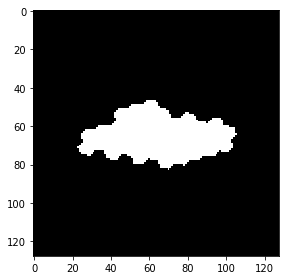

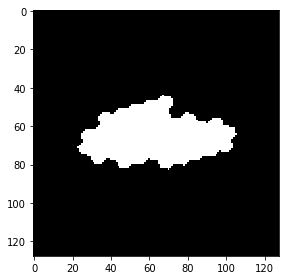

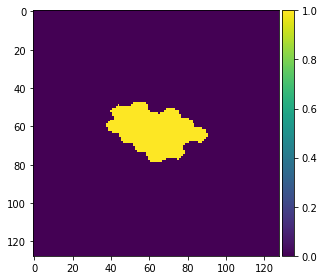

In [91]:
preds_train_t = (preds_train > 0.2)*1
preds_val_t = (preds_val > 0.5)
preds_test_t = (preds_test > 0.5)
ix = 21
a_f1 = X_train[:,:,:,4]
imshow(np.squeeze(a_f1[int(a_f1.shape[0]*0.7):][ix]))
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.7):][ix]))
plt.show()
imshow(np.squeeze(preds_train_t[int(preds_train_t.shape[0]*0.7):][ix]))
plt.show()

In [ ]:
print(preds_train_t)